In [2]:
import xarray as xr
import numpy as np
import rioxarray

In [9]:
#ds = xr.open_dataset('/work/mech-ai-scratch/rtali/gis-weather/final_weather/merged_dayl_2019.nc')
ds = xr.open_dataset('/work/mech-ai-scratch/rtali/gis-weather/final_processed_weather/daymet_iowa_2019.nc')
ds

<xarray.Dataset> Size: 2GB
Dimensions:                  (x: 539, y: 371, time: 365)
Coordinates:
  * x                        (x) float64 4kB 2.598e+05 2.608e+05 ... 7.978e+05
  * y                        (y) float64 3kB 1.5e+05 1.49e+05 ... -2.2e+05
  * time                     (time) datetime64[ns] 3kB 2019-01-01 ... 2019-12-31
Data variables:
    lambert_conformal_conic  int64 8B ...
    dayl                     (time, y, x) float32 292MB ...
    lat                      (y, x) float64 2MB ...
    lon                      (y, x) float64 2MB ...
    prcp                     (time, y, x) float32 292MB ...
    srad                     (time, y, x) float32 292MB ...
    swe                      (time, y, x) float32 292MB ...
    tmax                     (time, y, x) float32 292MB ...
    tmin                     (time, y, x) float32 292MB ...
    vp                       (time, y, x) float32 292MB ...
Attributes:
    start_year:          2019
    source:              Daymet Software Version 4.0
    Version_software:    Daymet Software Version 4.0
    Version_data:        Daymet Data Version 4.0
    Conventions:         CF-1.6
    citation:            Please see http://daymet.ornl.gov/ for current Dayme...
    references:          Please see http://daymet.ornl.gov/ for current infor...
    History:             Translated to CF-1.0 Conventions by Netcdf-Java CDM ...
    geospatial_lat_min:  39.97591721881702
    geospatial_lat_max:  43.880950040858615
    geospatial_lon_min:  -96.81426396587968
    geospatial_lon_max:  -89.6280561958434

In [10]:
# Ensure lat and lon are not treated as coordinates for reprojection
if 'lat' in ds.coords:
    ds = ds.reset_coords('lat')
if 'lon' in ds.coords:
    ds = ds.reset_coords('lon')
ds['lambert_conformal_conic']

<xarray.DataArray 'lambert_conformal_conic' ()> Size: 8B
[1 values with dtype=int64]
Attributes: (12/18)
    crs_wkt:                        PROJCS["unknown",GEOGCS["unknown",DATUM["...
    semi_major_axis:                6378137.0
    semi_minor_axis:                6356752.314245179
    inverse_flattening:             298.257223563
    reference_ellipsoid_name:       WGS 84
    longitude_of_prime_meridian:    0.0
    ...                             ...
    latitude_of_projection_origin:  42.5
    longitude_of_central_meridian:  -100.0
    false_easting:                  0.0
    false_northing:                 0.0
    spatial_ref:                    PROJCS["unknown",GEOGCS["unknown",DATUM["...
    GeoTransform:                   259250.0 1000.0 0.0 150500.0 0.0 -1000.0

In [11]:
print(ds.coords)

Coordinates:
  * x        (x) float64 4kB 2.598e+05 2.608e+05 ... 7.968e+05 7.978e+05
  * y        (y) float64 3kB 1.5e+05 1.49e+05 1.48e+05 ... -2.19e+05 -2.2e+05
  * time     (time) datetime64[ns] 3kB 2019-01-01 2019-01-02 ... 2019-12-31


In [12]:
# Extract CRS parameters
crs_var = ds['lambert_conformal_conic'].attrs
standard_parallel = crs_var.get('standard_parallel').tolist()
lon_0 = crs_var.get('longitude_of_central_meridian', -100.0)
lat_0 = crs_var.get('latitude_of_projection_origin', 42.5)
false_easting = crs_var.get('false_easting', 0.0)
false_northing = crs_var.get('false_northing', 0.0)
semi_major_axis = crs_var.get('semi_major_axis', 6378137.0)
inverse_flattening = crs_var.get('inverse_flattening', 298.257223563)

# Handle standard_parallel (two values in this case)
if isinstance(standard_parallel, (list, tuple, xr.DataArray)):
    lat_1, lat_2 = standard_parallel  # [25.0, 60.0]
    parallel_str = f"+lat_1={lat_1} +lat_2={lat_2}"
else:
    raise ValueError("Expected standard_parallel to be a list with two values")

# Construct Proj4 string with WGS84 ellipsoid parameters
lambert_crs = (
    f"+proj=lcc {parallel_str} +lat_0={lat_0} +lon_0={lon_0} "
    f"+x_0={false_easting} +y_0={false_northing} "
    f"+a={semi_major_axis} +f={1/inverse_flattening} +units=m +no_defs"
)
print(f"Constructed CRS: {lambert_crs}")

# Assign CRS to dataset
# Example with different coordinate names
ds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)
ds.rio.write_crs(lambert_crs, inplace=True)

Constructed CRS: +proj=lcc +lat_1=25.0 +lat_2=60.0 +lat_0=42.5 +lon_0=-100.0 +x_0=0.0 +y_0=0.0 +a=6378137.0 +f=0.0033528106647474805 +units=m +no_defs


<xarray.Dataset> Size: 2GB
Dimensions:                  (x: 539, y: 371, time: 365)
Coordinates:
  * x                        (x) float64 4kB 2.598e+05 2.608e+05 ... 7.978e+05
  * y                        (y) float64 3kB 1.5e+05 1.49e+05 ... -2.2e+05
  * time                     (time) datetime64[ns] 3kB 2019-01-01 ... 2019-12-31
    lambert_conformal_conic  int64 8B 0
Data variables:
    dayl                     (time, y, x) float32 292MB ...
    lat                      (y, x) float64 2MB ...
    lon                      (y, x) float64 2MB ...
    prcp                     (time, y, x) float32 292MB ...
    srad                     (time, y, x) float32 292MB ...
    swe                      (time, y, x) float32 292MB ...
    tmax                     (time, y, x) float32 292MB ...
    tmin                     (time, y, x) float32 292MB ...
    vp                       (time, y, x) float32 292MB ...
Attributes:
    start_year:          2019
    source:              Daymet Software Version 4.0
    Version_software:    Daymet Software Version 4.0
    Version_data:        Daymet Data Version 4.0
    Conventions:         CF-1.6
    citation:            Please see http://daymet.ornl.gov/ for current Dayme...
    references:          Please see http://daymet.ornl.gov/ for current infor...
    History:             Translated to CF-1.0 Conventions by Netcdf-Java CDM ...
    geospatial_lat_min:  39.97591721881702
    geospatial_lat_max:  43.880950040858615
    geospatial_lon_min:  -96.81426396587968
    geospatial_lon_max:  -89.6280561958434

In [14]:
# Reproject to WGS84 (EPSG:4326)
#ds = ds.drop_vars(['time_bnds'])
ds_reprojected = ds.rio.reproject('EPSG:4326')

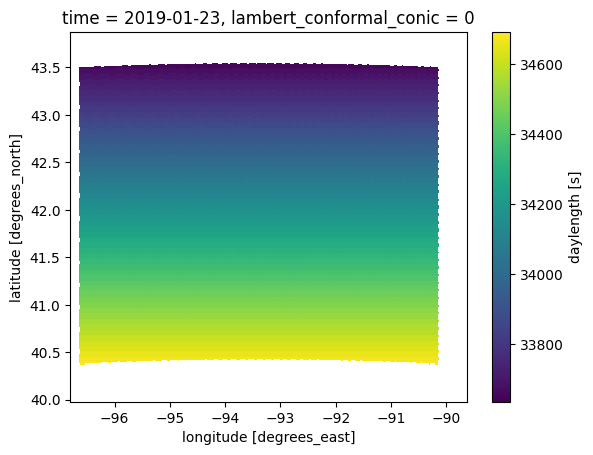

In [15]:
ds_reprojected.isel(time=22).dayl.plot()

In [17]:
for var in ds_reprojected.variables:
        if 'grid_mapping' in ds_reprojected[var].attrs:
            del ds_reprojected[var].attrs['grid_mapping']  # Remove the attribute
        if 'grid_mapping' in ds_reprojected[var].encoding:
            del ds_reprojected[var].encoding['grid_mapping']  # Remove from encoding if present

In [18]:
ds_reprojected.to_netcdf("temp.nc")

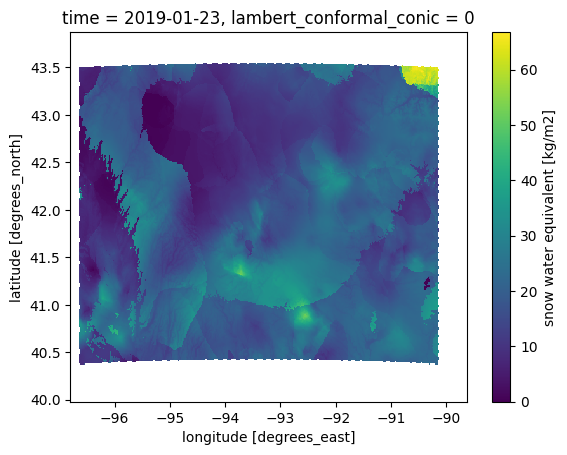

In [21]:
ds_reprojected.isel(time=22).swe.plot()

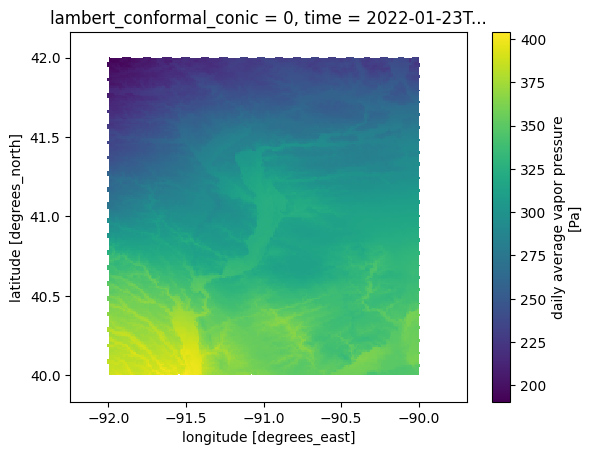

In [ ]:
# Check the reprojected files by tiles

ds_test = xr.open_dataset('./final_weather_v2/WGS84_11745_2022_vp.nc')
ds_test.isel(time=22).vp.plot()

None
None
None
None


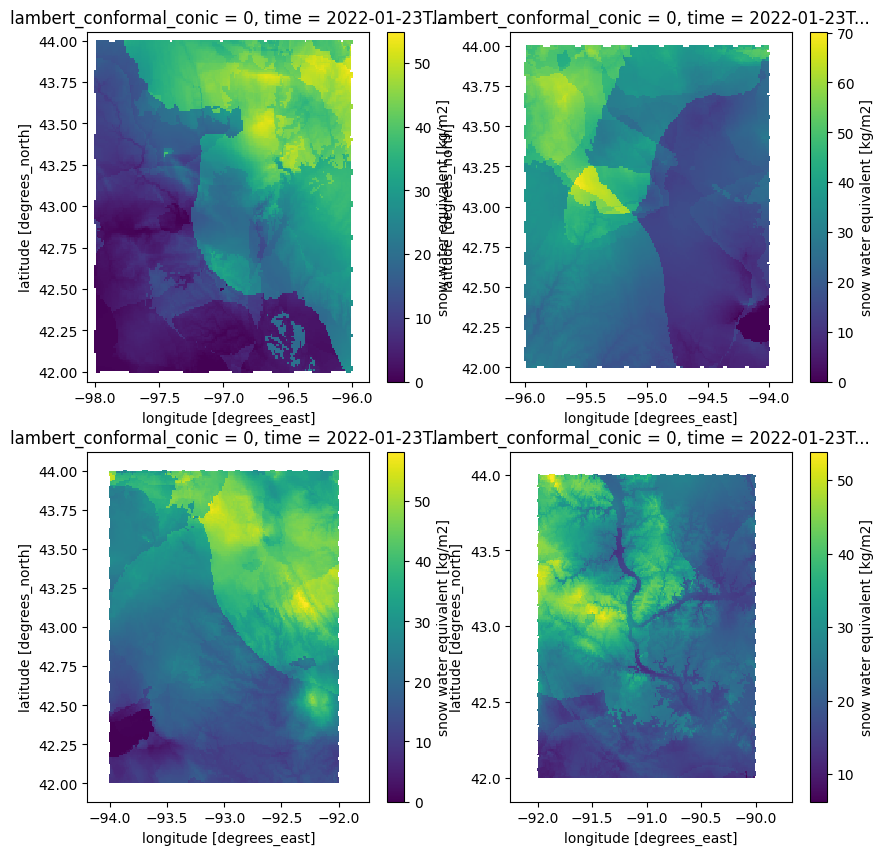

In [24]:
ds_test_1 = xr.open_dataset('./final_weather_v2/WGS84_11922_2022_swe.nc')
print(ds_test_1.rio.crs) # Check the CRS
ds_test_2 = xr.open_dataset('./final_weather_v2/WGS84_11923_2022_swe.nc')
print(ds_test_2.rio.crs) # Check the CRS
ds_test_3 = xr.open_dataset('./final_weather_v2/WGS84_11924_2022_swe.nc')
print(ds_test_3.rio.crs) # Check the CRS
ds_test_4 = xr.open_dataset('./final_weather_v2/WGS84_11925_2022_swe.nc')
print(ds_test_4.rio.crs) # Check the CRS

# Plot in 4 subplots 2x2
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
ds_test_1.isel(time=22).swe.plot(ax=axs[0, 0])
ds_test_2.isel(time=22).swe.plot(ax=axs[0, 1])
ds_test_3.isel(time=22).swe.plot(ax=axs[1, 0])
ds_test_4.isel(time=22).swe.plot(ax=axs[1, 1])
plt.show()

In [25]:
ds_test_1 = xr.open_dataset('./final_weather_v2/WGS84_11922_2022_swe.nc')
ds_test_1

<xarray.Dataset> Size: 60MB
Dimensions:                  (x: 206, y: 198, time: 365)
Coordinates:
  * x                        (x) float64 2kB -98.06 -98.04 ... -95.88 -95.87
  * y                        (y) float64 2kB 44.05 44.04 44.03 ... 41.96 41.95
    lambert_conformal_conic  int64 8B ...
    lat                      (y, x) float64 326kB ...
    lon                      (y, x) float64 326kB ...
  * time                     (time) datetime64[ns] 3kB 2022-01-01T12:00:00 .....
Data variables:
    yearday                  (time) int16 730B ...
    swe                      (time, y, x) float32 60MB ...
Attributes:
    tileid:            11922
    start_year:        2022
    source:            Daymet Software Version 4.0
    Version_software:  Daymet Software Version 4.0
    Version_data:      Daymet Data Version 4.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    grid_mapping:      latitude_longitude

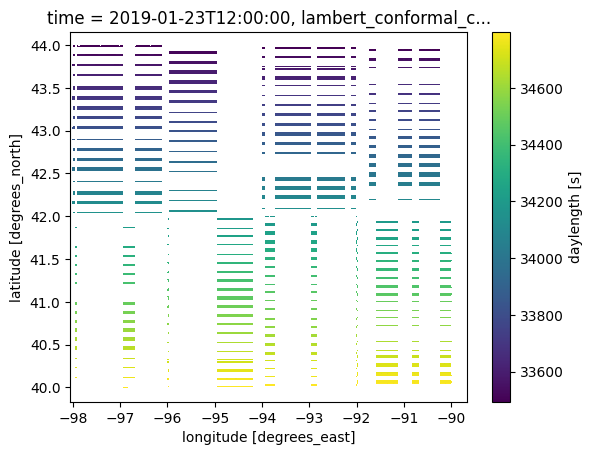

In [4]:
ds_dayl= xr.open_dataset('./final_processed_weather/merged_dayl_2019.nc')
ds_dayl = ds_dayl.sortby("y")
ds_dayl.isel(time=22).dayl.plot()

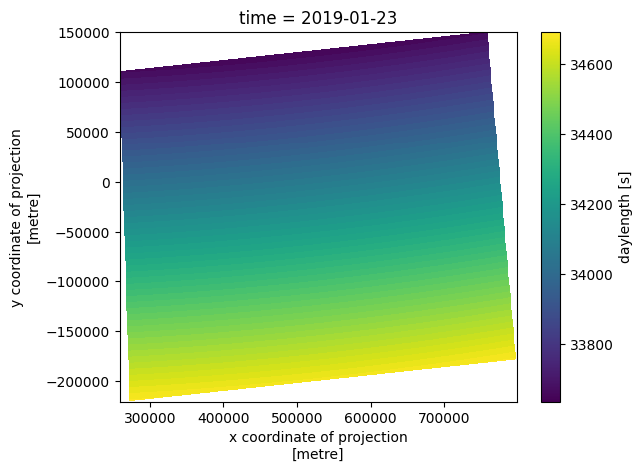

In [8]:
ds_dayl= xr.open_dataset('./final_processed_weather/daymet_iowa_2019.nc')
ds_dayl.isel(time=22).dayl.plot()

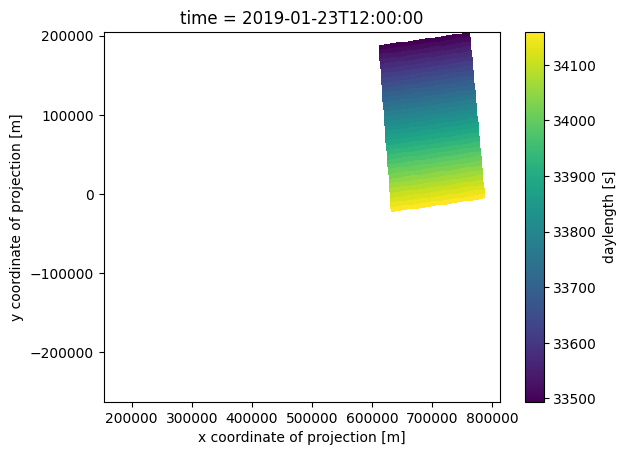

In [6]:
#Merge .nc files

import os
import glob

# List all .nc files in the current directory
nc_files = glob.glob('./download_by_tileIDs/2019/*/dayl.nc')

# Open all .nc files and concatenate them along the time dimension
ds_dayl = xr.open_mfdataset(nc_files, combine='nested', concat_dim='time')

#Plot the merged file
ds_dayl.isel(time=22).dayl.plot()
